In [4]:
# Load Dependencies
import matplotlib.pyplot as plt


import torch

import pyro
import numpy as np
import pyro.distributions as dist
from pyro.poutine import trace, replay, block
from pyro.infer.autoguide.guides import AutoDelta, AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
# from pyro.optim import Adam

import sys
sys.path.append("../")

from pyciemss.utils import run_inference, get_tspan

import warnings
warnings.filterwarnings('ignore')

/Users/sam-basis/opt/anaconda3/envs/askem-test/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Plotting Utilities

def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time /days')
    ax.set_ylabel('Infected (1000s)')
    return ax

def plot_predictive(prediction, tspan, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):
    vars = ["I_obs"]
    
    I_low = torch.quantile(prediction["I_obs"], 0.05, dim=0).detach().numpy()/1000
    I_up = torch.quantile(prediction["I_obs"], 0.95, dim=0).detach().numpy()/1000

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_trajectory(data, tspan, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data["I_obs"].squeeze().detach().numpy()/1000., color, alpha=alpha, lw=lw, marker=marker, label=label)
    
    return ax

def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

    return ax

In [6]:
# Setup Parameters

observed_tspan = get_tspan(1, 7, 7)
new_tspan = get_tspan(7, 89, 83)
full_tspan = get_tspan(1, 89, 89)

num_samples = 500

# Total population, N.
N = 100000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0 = 0., 81.0, 0., 0.
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

# 18 - 24 year olds
I_obs = torch.tensor([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])

initial_state = tuple(torch.as_tensor(s) for s in  (S0, V0, I0, Iv0, R0))
final_observed_state = tuple(torch.as_tensor(s) for s in  (S0, V0, I_obs[-1], Iv0, R0))


## Probabilistic Forecasting - Ignoring Historical Data

In [7]:
from pyciemss.ODE.models import SVIIvR

In [8]:
pyro.set_rng_seed(0)

noisy_ode_model = SVIIvR(N, 
                noise_prior=dist.Uniform(5., 10.),
                beta_prior=dist.Uniform(0.1, 0.3), 
                betaV_prior=dist.Uniform(0.025, 0.05),
                gamma_prior=dist.Uniform(0.05, 0.35),
                gammaV_prior=dist.Uniform(0.1, 0.4),
                nu_prior=dist.Uniform(0.001, 0.01))

ode_model = pyro.do(noisy_ode_model, {"noise_var": torch.tensor([0.000001])})

prior_prediction = Predictive(ode_model, num_samples=num_samples)(initial_state, full_tspan)
single_prediction = Predictive(ode_model, num_samples=1)(initial_state, full_tspan)

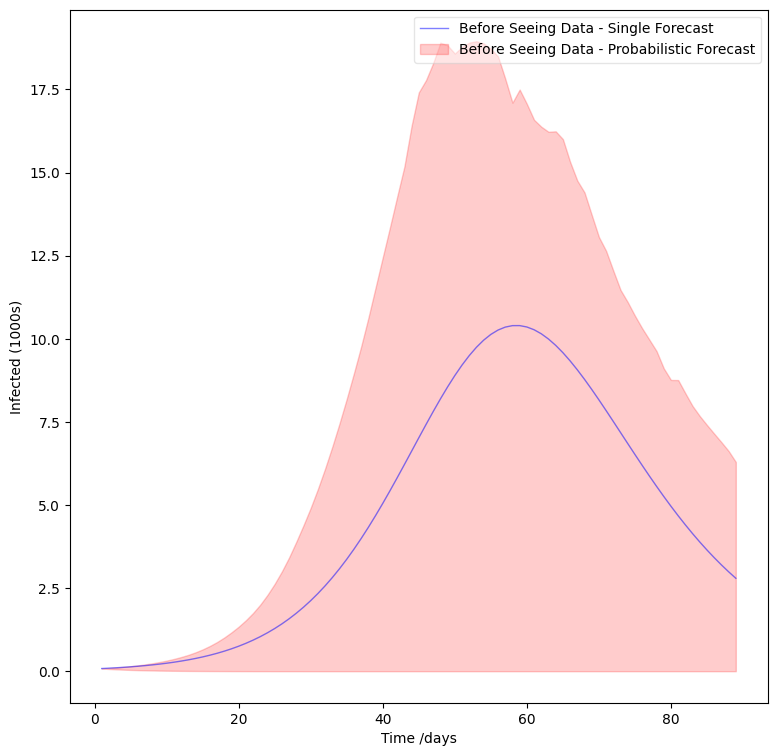

In [9]:

ax = plot_trajectory(single_prediction, full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")

## Forecasting - Incorporating Historical Data

In [10]:
pyro.set_rng_seed(0)

guide = AutoNormal(block(noisy_ode_model, hide=["S_obs", "V_obs", "R_obs"]))
map_guide = AutoDelta(block(noisy_ode_model, hide=["S_obs", "V_obs", "R_obs"]))

data = {"S_obs":None, "V_obs":None, "I_obs":I_obs, "R_obs":None}

run_inference(noisy_ode_model, guide, initial_state, observed_tspan, data, num_iterations=200, verbose=False)
run_inference(noisy_ode_model, map_guide, initial_state, observed_tspan, data, num_iterations=200, verbose=False)

map_prediction = Predictive(ode_model, guide=map_guide, num_samples=1)(final_observed_state, new_tspan)
posterior_prediction = Predictive(ode_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

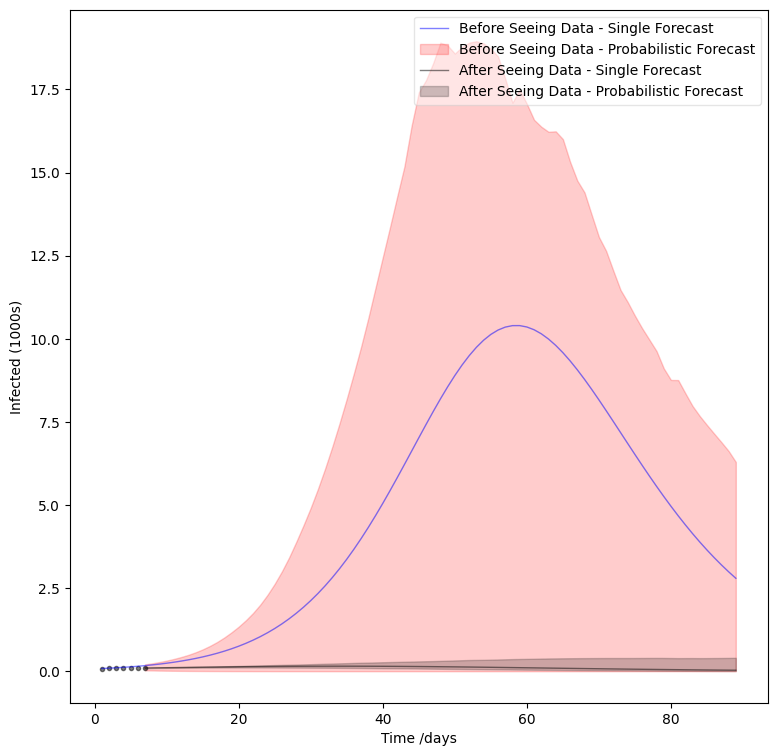

In [11]:

ax = plot_trajectory(data, observed_tspan, ax=setup_ax())
ax = plot_trajectory(single_prediction, full_tspan, ax=ax, color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")
ax = plot_predictive(prior_prediction, full_tspan, tmin=7, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")
ax = plot_trajectory(map_prediction, new_tspan, ax=ax, marker='', lw=1., label="After Seeing Data - Single Forecast")
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast")

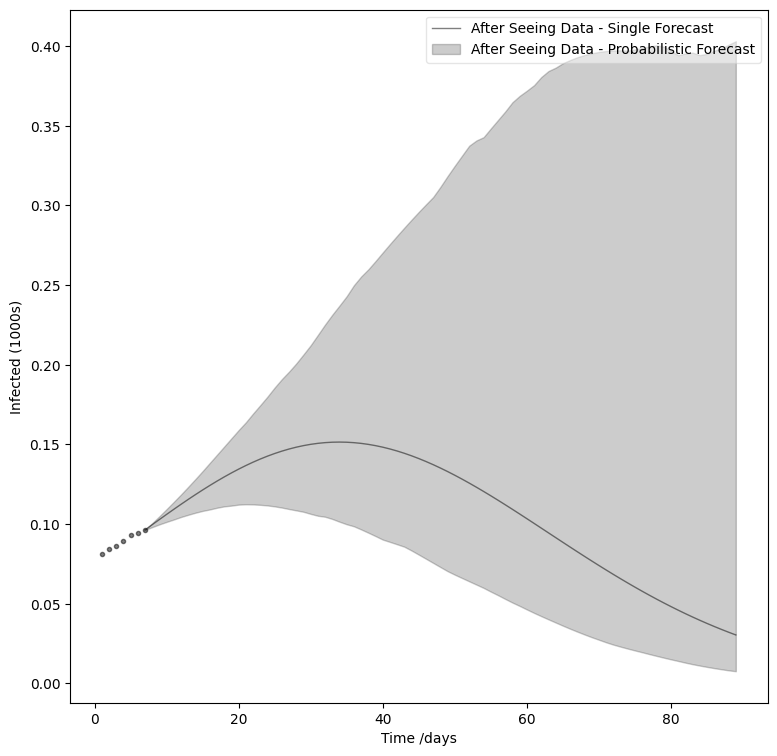

In [12]:

ax = plot_trajectory(data, observed_tspan, ax=setup_ax())
ax = plot_trajectory(map_prediction, new_tspan, ax=ax, marker='', lw=1., label="After Seeing Data - Single Forecast")
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast")

## Probabilistic Forecasting - Exploring Possible Interventions

In [13]:
from causal_pyro.query.do_messenger import do
from pyciemss.ODE.interventions import constant_intervention, time_dependent_intervention, state_dependent_intervention, parameter_intervention

In [14]:
pyro.set_rng_seed(0)

rate_parameter_intervention = parameter_intervention("nu", torch.tensor([0.01]))
intervened_parameter_model = do(ode_model, rate_parameter_intervention)
intervened_parameter_prediction = Predictive(intervened_parameter_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

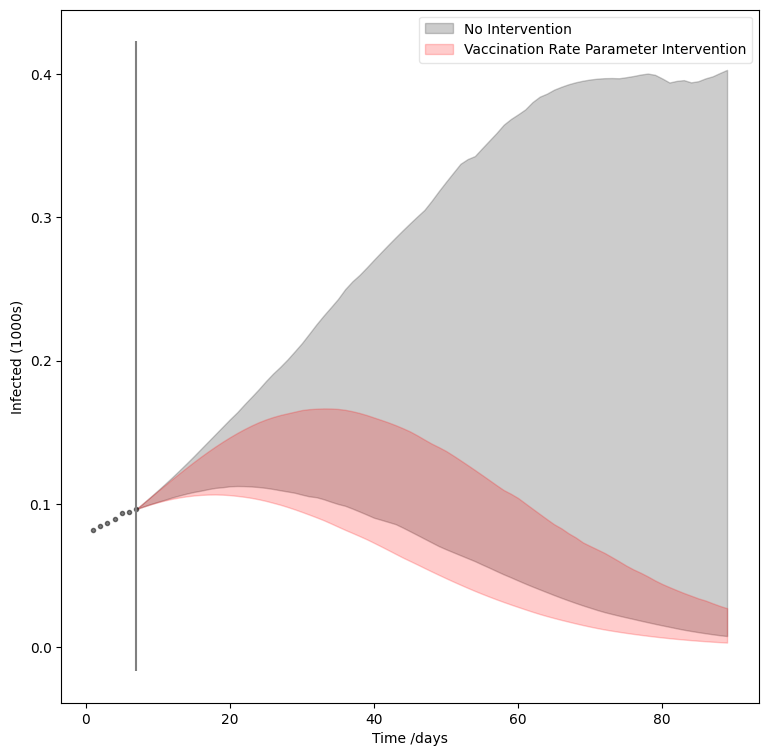

In [15]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)

In [16]:
pyro.set_rng_seed(0)

rate_intervention = constant_intervention("SV_flux", torch.tensor([500.]), full_tspan)
rate_intervention_model = do(ode_model, rate_intervention)
rate_intervention_prediction = Predictive(rate_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

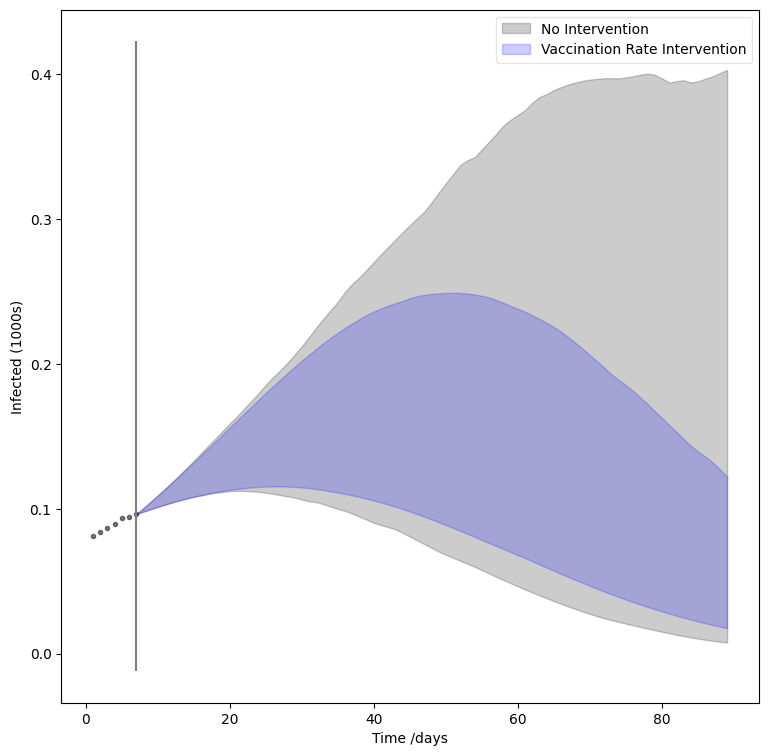

In [17]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, ax=ax, color='blue', label="Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)

In [18]:
pyro.set_rng_seed(0)

def ramping_rate_up_intervention_function(t):
    month = torch.floor(t / 30.).int()
    return torch.tensor([500.0, 750.0, 1000.])[month]

ramping_rate_up_intervention = time_dependent_intervention("SV_flux", ramping_rate_up_intervention_function, new_tspan)
ramping_rate_up_intervention_model = do(ode_model, ramping_rate_up_intervention)
ramping_rate_up_intervention_prediction = Predictive(ramping_rate_up_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

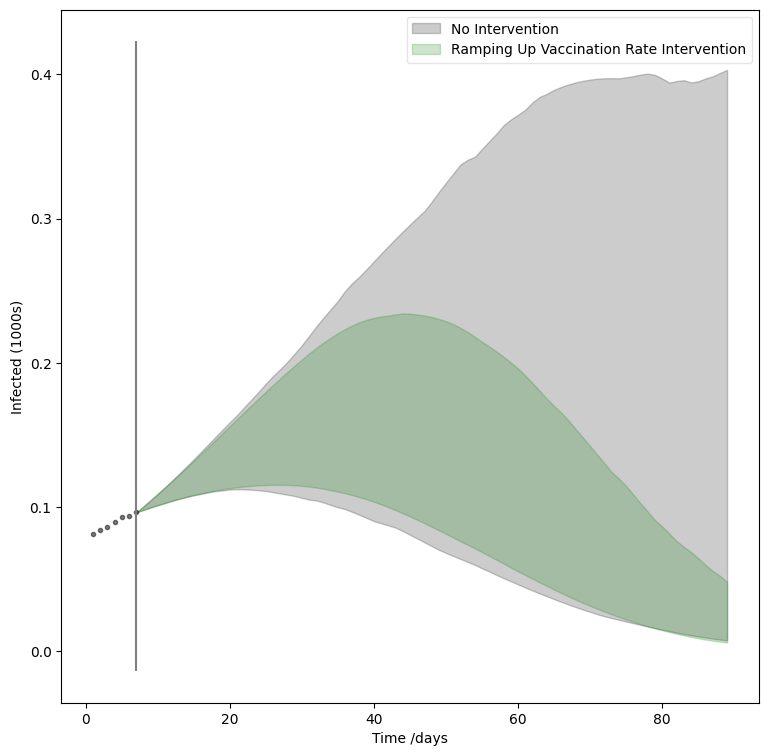

In [19]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(ramping_rate_up_intervention_prediction, new_tspan, ax=ax, color='green', label="Ramping Up Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)

In [20]:
pyro.set_rng_seed(0)

def vaccination_encouragement_intervention_function(SV_flux):
    return SV_flux + torch.tensor([500.])

vaccination_encouragement_intervention = state_dependent_intervention("SV_flux", vaccination_encouragement_intervention_function, new_tspan)
vaccination_encouragement_intervention_model = do(ode_model, vaccination_encouragement_intervention)
vaccination_encouragement_intervention_prediction = Predictive(vaccination_encouragement_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

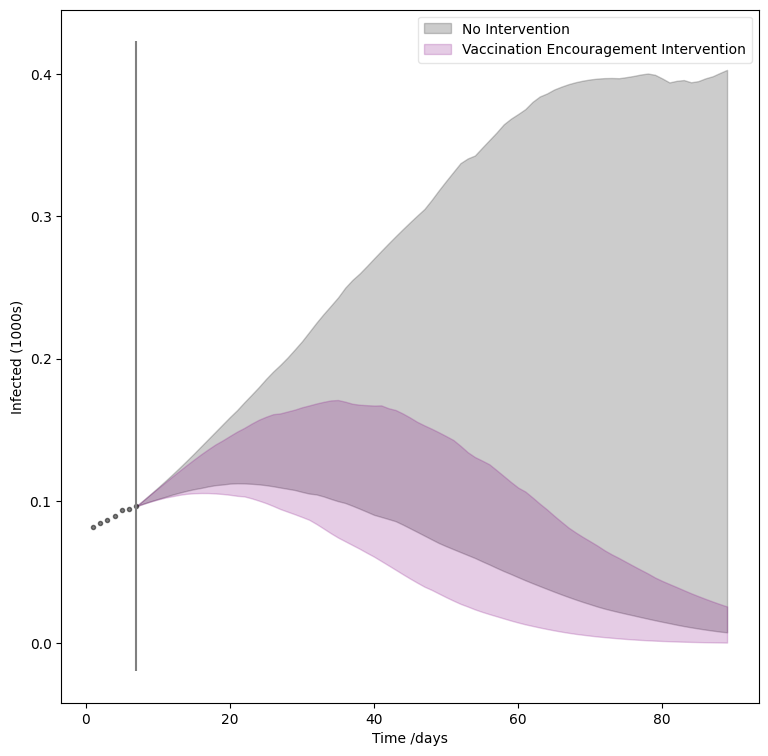

In [21]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, color='black', label="No Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, ax=ax, color='purple', label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)

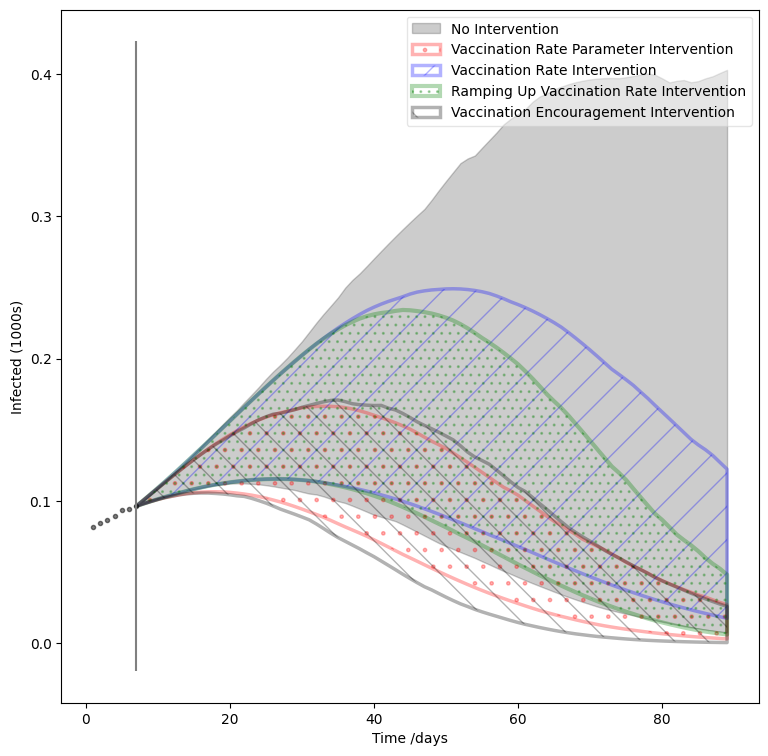

In [22]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, color='black', ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, hatch='.', edgecolor="red", linewidth=2.5, facecolor="none", ax=ax, alpha=0.3, label="Vaccination Rate Parameter Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, hatch='/', ax=ax, alpha=0.3, linewidth=2.5, edgecolor='blue', facecolor="none", label="Vaccination Rate Intervention")
ax = plot_predictive(ramping_rate_up_intervention_prediction, new_tspan, hatch='..', linewidth=3, ax=ax, alpha=0.3, edgecolor='green', facecolor="none", label="Ramping Up Vaccination Rate Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, hatch="\\", linewidth=2.5, ax=ax, alpha=0.3, edgecolor='black', facecolor="none", label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)

In [23]:
pyro.set_rng_seed(0)

stratified_intervention = state_dependent_intervention("SV_flux_18-24", vaccination_encouragement_intervention_function, new_tspan)
stratified_intervention_model = do(ode_model, stratified_intervention)

In [46]:

import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    value.__cause__ = None  # suppress chained exceptions
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

raise ValueError("The Intervention Variable SV_flux_18-24 is not defined and can not be intervened on. To fix this error, revise the model to include SV_flux_18-24").with_traceback(None) from None

ValueError: The Intervention Variable SV_flux_18-24 is not defined and can not be intervened on. To fix this error, revise the model to include SV_flux_18-24

In [20]:



# (experimental conditions, replicates, attributes, timesteps,)
data_cube = torch.zeros((5, 500, 4, 83))

for i, var in enumerate(["S_obs", "V_obs", "I_obs", "R_obs"]):
    for j, prediction in enumerate([posterior_prediction, intervened_parameter_prediction, rate_intervention_prediction, ramping_rate_up_intervention_prediction, vaccination_encouragement_intervention_prediction]):
        data_cube[j, :, i, :] = prediction[var]

data_cube = data_cube.detach().numpy()

import numpy as np
import pickle

np.save("datacube.npy", data_cube)

d = {"experimental conditions":["no_intervention", "intervened_parameter", "intervened_rate", "ramping_intervention", "encouragement_interventions"],
    "replicates": [i for i in range(500)],
     "attributes":["S", "V", "I", "R"],
     "timesteps": [i.detach().item() for i in new_tspan]}

with open("dimensions.pkl", 'wb') as f:
    pickle.dump(d, f)


## Optimization - Translating the Scenario Problem into Risk-based Optimization

Quantity of interest : 7 day average infections

controls : all the interventions from before

Anirban TODO: Show a bit of latex math and corresponding illustrations

## Optimization - Finding the Optimal Risk-aware Decision

In [ ]:
# # Anirban TODO.

# use_posterior = True

# intervention_assignment = torch.tensor([0., 0., 0.], requires_grad=True)
# optimizer = torch.optim.Adam([intervention_assignment], lr=0.05)


# # TODO: line this up with the scheduled_intervention controlled_models from before.
# controlled_model = lambda int : do(ode_model, scheduled_intervention())(initial_state, tspan)

# for i in range(500):
#     if use_posterior:
#         # Sample from the approximate posterior and replay through the model.
#         # Note: Because we're using the Pytorch optimizer that targets tensors, we don't need to freeze guide parameters.
#         guide_tr = trace(guide).get_trace(initial_state, tspan)
#         model_tr = trace(replay(controlled_model, trace=guide_tr)).get_trace(intervention_assignment)
#     else:
#         model_tr = trace(controlled_model).get_trace(intervention_assignment)

#     # If this value is positive, the constraint is not satisfied.
#     relaxed_constraint = torch.max(model_tr.nodes["R_obs"]['value'][-1] - torch.tensor([100.]), torch.tensor([0.]))

#     # Relaxed constrained optimization (flux is negative by default, therefore we want to penalize "smaller" flux values.)
#     loss = -intervention_assignment + relaxed_constraint

#     optimizer.zero_grad()
#     loss.backward()

#     if i % 10 == 0:
#         print("[iteration %04d] loss: %.4f [intervention_assignment %.4f]" % (i + 1, loss, intervention_assignment))

#     optimizer.step()